In [1]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tqdm import tqdm


### Implementation of the model
1. Implement the above model, i. e., solve the corresponding ODE system by a suitable integrator of your
choice.
Hint: Using existing libraries is recommended.
2. Plot the curves of S, E, I, and R to demonstrate a reasonable solution.
3. Play with different values for the parameter x and check their intuition


In [ ]:
#Problem statement and parameter setup
N = 80_000_000 #int
T = 60  # weeks
t_eval = np.arange(0, T + 0.1, 0.1)
t_weekly = np.arange(0, T + 1, 1)

# vector of model para
x0 = np.array([14/9, 7/3, 7/9, 1000])  # list of [beta, alpha, gamma, I0] to numpy array for calculation

In [7]:
#1 --- SEIR
def seir_with_cumulative(t, y, beta, alpha, gamma):
    S, E, I, R, C = y #y as current vector to store compartment values
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    dCdt = alpha * E
    return [dSdt, dEdt, dIdt, dRdt, dCdt]


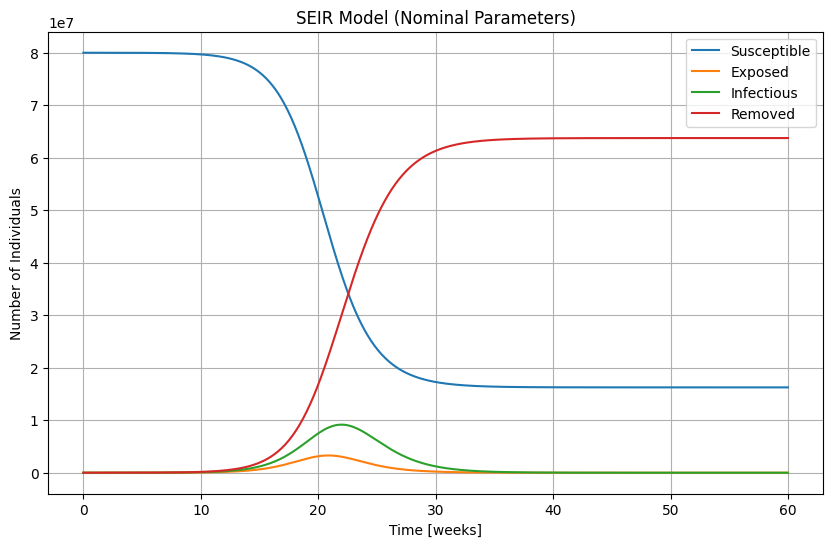

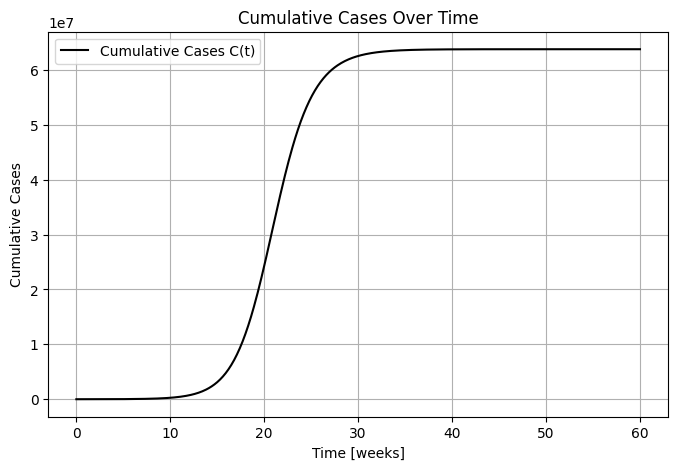

In [8]:
#-- Nominal Run ---
def nominal_run():
    beta, alpha, gamma, I0 = x0
    S0 = N - I0
    y0 = [S0, 0, I0, 0, 0] #initial values at t=0
    sol = solve_ivp(seir_with_cumulative, [0, T], y0, args=(beta, alpha, gamma), t_eval=t_eval)
    S, E, I, R, C = sol.y #unpack each var: compartment across time
    plt.figure(figsize=(10,6))
    plt.plot(t_eval, S, label='Susceptible')
    plt.plot(t_eval, E, label='Exposed')
    plt.plot(t_eval, I, label='Infectious')
    plt.plot(t_eval, R, label='Removed')
    plt.title('SEIR Model (Nominal Parameters)')
    plt.xlabel('Time [weeks]')
    plt.ylabel('Number of Individuals')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(8,5))
    # 5. Cumulative Case Model ---
    # 6. Add an appropriate corresponding initial value C0 = C(0). WE SET =0  in y0
    # 7. Plot the curve for C(t) with parameter x0= [14/9, 7/3, 7/9, 1000]
    plt.plot(t_eval, C, label='Cumulative Cases C(t)', color='black')
    plt.title('Cumulative Cases Over Time')
    plt.xlabel('Time [weeks]')
    plt.ylabel('Cumulative Cases')
    plt.grid(True)
    plt.legend()
    plt.show()
    
nominal_run()

#### graph1(dymanics of the epidemic): 
Over 60w, slightly over a year:
- Susceptible: full population then dropped as more people are exposed to infection
- Exposed: the num of People who are infected but not yet infectious rises initially, then falls as transition to the Infectious stage.
- I: outbreaks as over week 20
- R (Removed): Includes recovered or deceased individuals. Increases over time as people leave the Infectious state, and flattens out as the epidemic ends.
#### graph2: total number of cases that have ever been infected
=>  total number of individuals ever infected by the end of the simulation for public health planning
sigmoid shape: starts slowly at first and reached outbreak at over week 20, plateu at w 40-60
Almost everyone eventually gets infected (since C(t) approaches N ) => widespread.



4. Depending on a nominal parameter value x0, we , i. e., subtract
and add pk, k = 1, 2, from and to each parameter value x0,j , j = 1, . . . , n. This yields an interval for each
parameter and hence eventually results in hypercubes Hk.
Define Hk formally, i. e., in mathematical terms (like Hk = . . .)

=> 2X4 VECTOR/ARRAY (X_LOWER<1x4>, X_UPPER<1x4>)=> HYPERCUBE (why is it hypercube 2x3 though? it should be tesseract)

In [12]:
p1 = 0.05
p2 = 0.10
# 4. DEFINE HYPERCUBE by pertubation each parameter by p1 = 5% and p2 = 10%
def create_hypercube(x0, p):
    # SUBSTRACT AND ADD Pk TO EACH COMPONENT VALUE IN PARAMETER VECTOR x0
    lower = x0 * (1 - p)
    upper = x0 * (1 + p)
    return lower, upper

H1 = create_hypercube(x0, p1)
H2 = create_hypercube(x0, p2)
print(H1)

(array([1.47777778e+00, 2.21666667e+00, 7.38888889e-01, 9.50000000e+02]), array([1.63333333e+00, 2.45000000e+00, 8.16666667e-01, 1.05000000e+03]))


In [ ]:

# after TUNING THE NOMINAL PARAMETER BY DEFINING HYPERCUBE, 
# 3. Play with different values for the parameter x and check their intuition.
# 8.Create N = 1000 sample and compute
def sample_parameters(lower, upper, N_samples=1000):
    return np.random.uniform(lower, upper, size=(N_samples, len(lower)))

def solve_all_samples(params_set):
    solutions = []
    for params in tqdm(params_set):
        beta, alpha, gamma, I0 = params
        S0 = N - I0
        y0 = [S0, 0, I0, 0, 0]
        sol = solve_ivp(
            seir_with_cumulative, [0, T], y0,
            args=(beta, alpha, gamma), t_eval=t_weekly ) #8. time step= 1w
        solutions.append((sol.t, sol.y))
    return solutions



--- Running simulations for H1 (5% perturbation) ---


100%|██████████| 1000/1000 [00:05<00:00, 189.45it/s]


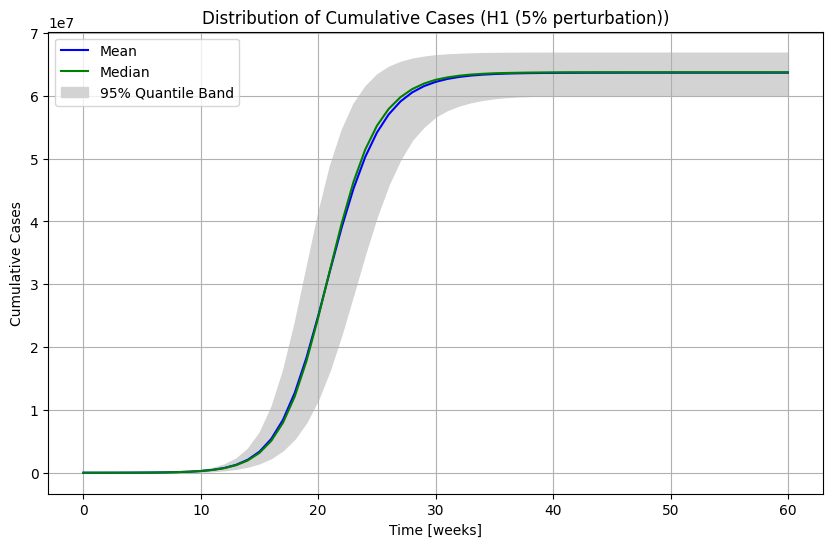

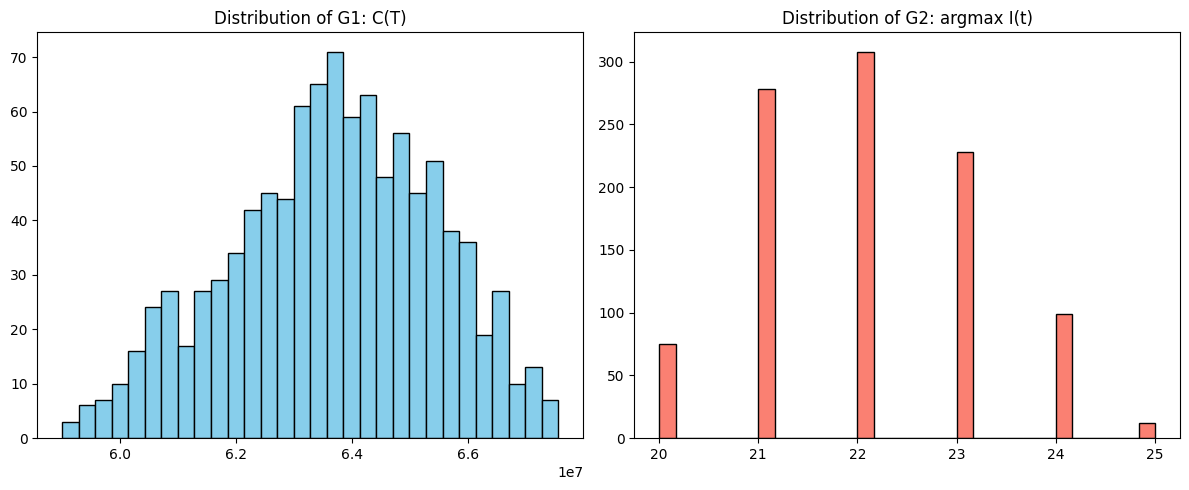

95% Quantile Interval for G1 (C(T)): [60134621.08913279 66854962.17064738]
95% Quantile Interval for G2 (argmax I): [20. 24.]
Pearson Correlation Coefficient between G1 and G2: -0.9156762735041829


In [13]:
def extract_C_and_peak_I(solutions):
    C_curves = np.array([sol[1][4] for sol in solutions])
    G1 = C_curves[:, -1]
    G2 = [np.argmax(sol[1][2]) for sol in solutions]
    return C_curves, G1, G2

#9. Plot the (empirical) distribution of the curve C(t; X), i. e., plot the mean and median along with a
# 95% quantile band showing the distance between the 2.5% and 97.5% quantile at each simulated point in
# time. Hint: For the computation of (empirical) quantiles, using existing libraries is recommended.
def plot_stats_C(C_curves, label):
    mean_C = np.mean(C_curves, axis=0)
    median_C = np.median(C_curves, axis=0)
    q2p5 = np.quantile(C_curves, 0.025, axis=0)
    q97p5 = np.quantile(C_curves, 0.975, axis=0)
    plt.figure(figsize=(10,6))
    plt.plot(t_weekly, mean_C, label='Mean', color='blue')
    plt.plot(t_weekly, median_C, label='Median', color='green')
    plt.fill_between(t_weekly, q2p5, q97p5, color='lightgray', label='95% Quantile Band')
    plt.title(f'Distribution of Cumulative Cases ({label})')
    plt.xlabel('Time [weeks]')
    plt.ylabel('Cumulative Cases')
    plt.legend()
    plt.grid(True)
    plt.show()

#10. Plot the (empirical) distribution of G1(X) and G2(X).
def plot_G1_G2(G1, G2):
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.hist(G1, bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of G1: C(T)')
    plt.subplot(1, 2, 2)
    plt.hist(G2, bins=30, color='salmon', edgecolor='black')
    plt.title('Distribution of G2: argmax I(t)')
    plt.tight_layout()
    plt.show()
    
#11. Compute empirical 95% intervals for G₁ and G₂
#12. Estimate Pearson correlation between G₁ and G2
def compute_intervals(G1, G2):
    g1_interval = np.quantile(G1, [0.025, 0.975])
    g2_interval = np.quantile(G2, [0.025, 0.975])
    print("95% Quantile Interval for G1 (C(T)):", g1_interval)
    print("95% Quantile Interval for G2 (argmax I):", g2_interval)
    corr, _ = pearsonr(G1, G2)
    print("Pearson Correlation Coefficient between G1 and G2:", corr)

def full_run_hypercube(label, H):
    print(f"\n--- Running simulations for {label} ---")
    samples = sample_parameters(*H)
    solutions = solve_all_samples(samples)
    C_curves, G1, G2 = extract_C_and_peak_I(solutions)
    plot_stats_C(C_curves, label)
    plot_G1_G2(G1, G2)
    compute_intervals(G1, G2)

full_run_hypercube("H1 (5% perturbation)", H1)



--- Running simulations for H2 (10% perturbation) ---


100%|██████████| 1000/1000 [00:05<00:00, 180.05it/s]


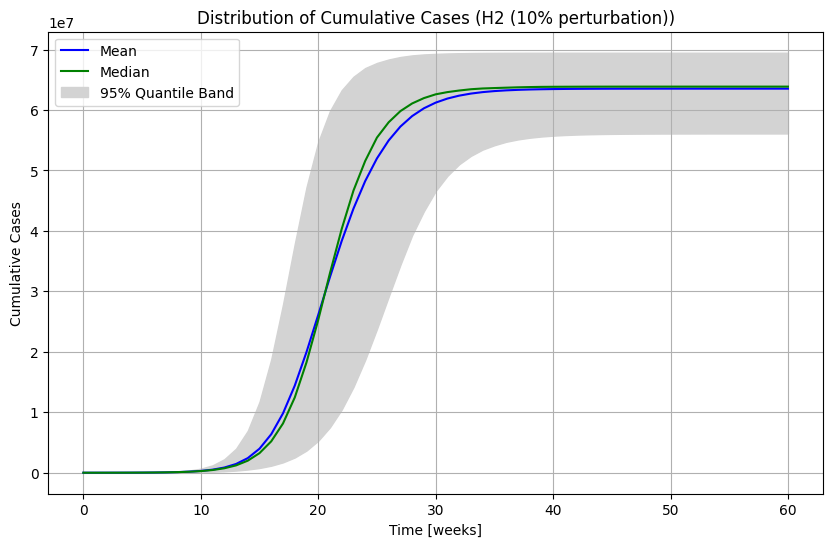

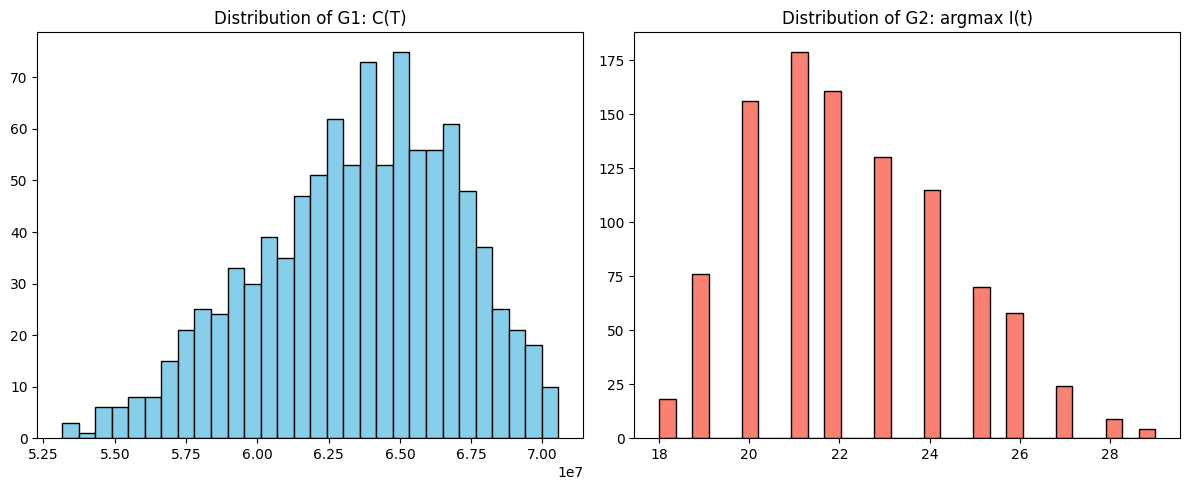

95% Quantile Interval for G1 (C(T)): [56113741.11306543 69468749.39288901]
95% Quantile Interval for G2 (argmax I): [19. 27.]
Pearson Correlation Coefficient between G1 and G2: -0.9323323259605989


In [14]:
full_run_hypercube("H2 (10% perturbation)", H2)

# Epidemic Forecast Analysis

## 1. Cumulative Cases

| **Description**                               | **H1**                                                        | **H2**                                                        |
|-----------------------------------------------|---------------------------------------------------------------|---------------------------------------------------------------|
| **95% Quantile range**                     | [60,134,621 to 66,854,962] (approx. 6.7 million spread)      | [56,113,741 to 69,468,749] (approx. 13.3 million spread)     |
| **Quantile Band**                             | Narrower quantile band ⇒ Lower uncertainty in total case numbers | Wider quantile band ⇒ Greater variability and broader range of potential outbreak trajectories |
| **Convergence**                               | Faster convergence ⇒ More predictable epidemic progression with fewer outlier scenarios | Greater separation mean and median ⇒ Less predictable outbreak path with more extreme scenarios possible |


---

## 2. Total Cumulative Cases Distribution

| **Description**                               | **H1**                                                        | **H2**                                                        |
|-----------------------------------------------|---------------------------------------------------------------|---------------------------------------------------------------|
| **Distribution**                              | Tighter distribution ⇒ More consistent total case counts, centered around 6.4-6.6 million | Broader distribution ⇒ Greater variability, with possible outcomes ranging from 5.5 to 7.0 million |

---

## 3. Peak Infection Times

| **Description**                               | **H1**                                                        | **H2**                                                        |
|-----------------------------------------------|---------------------------------------------------------------|---------------------------------------------------------------|
| **Peak Timing**                               | Focused peak ⇒ Narrow range of peak times, concentrated around 21-23 weeks | Wider peak range ⇒ Broader spread, spanning 19 to 27 weeks, indicating greater timing uncertainty |
| **95% Quantile Interval**                     | [20, 24] weeks                                                | [19, 27] weeks                                                |

### Pearson Correlation

| **Description**                               | **H1**                                                        | **H2**                                                        |
|-----------------------------------------------|---------------------------------------------------------------|---------------------------------------------------------------|
| **Pearson Correlation**                       | -0.916 (strong negative correlation, earlier peaks tend to have higher total cases) | -0.932 (stronger negative correlation, reflecting a more pronounced inverse relationship) |
